In [47]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import *
from sklearn.tree import export_graphviz

dataframe = {
    'age':[23, 45, 44, 20, 49, 56, 55, 43, 23, 67],
    'target':[6, 8, 10, 12, 15, 10, 14, 20, 11, 6]
}

data = pd.DataFrame(dataframe)


y = data.pop('target').values
feat_labels = data.columns
X = data.values


class SimpleGradientBoostingRegressor(BaseEstimator):

    def mse_antigradient(self, y_hat, y_true):
        return 2 * (y_true - y_hat)
    
    def mae_antigradient(self, y_hat, y_true):
        return np.sign(y_true - y_hat)
    
    def rmsle_antigradient(self, y_true, y_hat):
        eps = np.finfo(np.float64).eps
        return np.log1p(y_true) - np.log1p(np.clip(y_hat, eps, None))
    
    def huber_antigradient(self, y_hat, y_true):

        ath_quantile = self.ath_quantile
        delta_huber = np.quantile(abs(y_true - y_hat), ath_quantile)
        huber_vector = np.where(abs(y_true - y_hat) <= delta_huber, y_true - y_hat, delta_huber * np.sign(y_true - y_hat))

        return huber_vector
    
    def __init__(self, n_estimators=100, learning_rate=.1, loss='mse',
                        ath_quantile=None, constant='zero', max_depth=3,
                        subsample=1.0, random_state=17, debug=True):
        
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.loss = loss
        self.ath_quantile = ath_quantile
        self.constant = constant
        self.max_depth = max_depth
        self.subsample = subsample
        self.random_state = random_state
        self.debug = debug

        self.trees = []
        self.obj_by_iter = []

        if self.debug:
            self.pseudoresiduals = []
            self.idx_sampled = []
            self.tree_pred = []

    def fit(self, X, y):
        if self.constant == 'zero':
            prediction = 0

        if self.constant == 'mean':
            prediction = np.mean(y)

        if self.constant == 'median':
            prediction = np.median(y)
        
        if self.debug:
            self.const_pred = np.array([prediction] * len(X), float)

        if self.loss == 'mse':
            antigradient = self.mse_antigradient
        elif self.loss == 'mae':
            antigradient = self.mae_antigradient
        elif self.loss == 'rmsle':
            antigradient = self.rmsle_antigradient
        elif self.loss == 'huber':
            antigradient = self.huber_antigradient
        
        for iter_num in range(self.n_estimators):
            pseudoresid = antigradient(prediction, y)

            if self.debug:
                self.pseudoresiduals.append(pseudoresid)

            np.random.seed(iter_num)
            idx = np.random.choice(X.shape[0],
                                        int(self.subsample * X.shape[0]),
                                        replace=False)
            X_sampled = np.take(X, idx, axis=0)
            pseudoresid_sampled = np.take(pseudoresid, idx, axis=0)

            if self.debug:
                self.idx_sampled.append(idx)

            tree = DecisionTreeRegressor(max_depth=self.max_depth,
                                            random_state=self.random_state)
            tree.fit(X, pseudoresid)

            pred = tree.predict(X)

            if self.debug:
                self.tree_pred.append(pred)

            self.trees.append(tree)

            prediction += self.learning_rate * tree.predict(X)

            obj = mean_squared_error(y, prediction)
            self.obj_by_iter.append(obj)
        
        return self

    def predict(self, X):
        if self.constant == 'zero':
            pred = np.zeros(X.shape[0])

        elif self.constant == 'mean':
            pred = np.mean(y) * np.ones(X.shape[0])

        elif self.constant == 'median':
            pred = np.median(y) * np.ones(X.shape[0])

        for iter_num in range(self.n_estimators):
            pred += self.learning_rate * self.trees[iter_num].predict(X)

        return pred
    

boost = SimpleGradientBoostingRegressor(
    n_estimators=3, learning_rate=.3,
    constant='zero', loss='mse',
    max_depth=1, random_state=42)

boost.fit(X, y)

SimpleGradientBoostingRegressor(learning_rate=0.3, max_depth=1, n_estimators=3,
                                random_state=42)

In [48]:
pred = boost.predict(X)
pred

array([10.55895238, 10.74190476, 10.74190476, 10.55895238, 10.74190476,
       10.74190476, 10.74190476, 12.17038095, 10.55895238,  7.2752381 ])

In [53]:
obj_history_lst = []
for i in ['mse','mae', 'huber']:

    boost = SimpleGradientBoostingRegressor(
        n_estimators=20, learning_rate=.3, loss=i,
        ath_quantile=.95, max_depth=1,random_state=42)
    
    boost.fit(X, y)
    obj_history = boost.obj_by_iter
    obj_history_lst.append(obj_history)

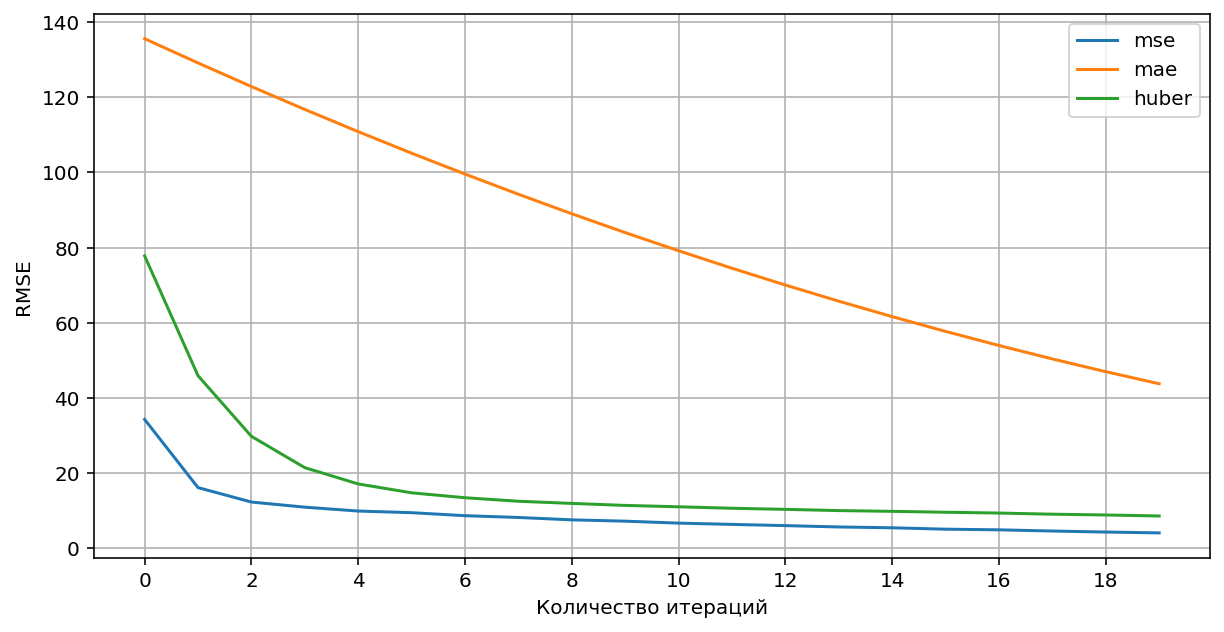

In [54]:
plt.figure(figsize=(10,5))
plt.plot(range(len(obj_history_lst[0])), obj_history_lst[0], label='mse')
plt.plot(range(len(obj_history_lst[1])), obj_history_lst[1], label='mae')
plt.plot(range(len(obj_history_lst[2])), obj_history_lst[2], label='huber')
plt.xticks(np.arange(0, 20, step=2))
plt.xlabel('Количество итераций')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()

In [55]:
df = pd.read_csv('Data/exam.csv', sep=';')
df.head()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
0,0,40.0,0.0,1400.0,1.0,Yes,No,No,No,Yes,No,63.0
1,1,48.0,4.0,2850.0,3.0,Yes,No,No,No,No,No,86.0
2,2,39.0,0.0,1200.0,1.0,No,No,No,No,No,No,53.0
3,3,46.0,5.0,1400.0,1.0,No,No,No,No,No,No,56.0
4,4,43.0,1.0,1500.0,1.0,No,No,No,No,No,No,59.0


In [57]:
del df['Id']

In [58]:
df.head()

,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
0,40.0,0.0,1400.0,1.0,Yes,No,No,No,Yes,No,63.0
1,48.0,4.0,2850.0,3.0,Yes,No,No,No,No,No,86.0
2,39.0,0.0,1200.0,1.0,No,No,No,No,No,No,53.0
3,46.0,5.0,1400.0,1.0,No,No,No,No,No,No,56.0
4,43.0,1.0,1500.0,1.0,No,No,No,No,No,No,59.0


In [59]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('mean_exam_points', axis=1),
    df['mean_exam_points'],
    test_size=.3,
    random_state=42
)

In [60]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

In [62]:
X_test

,age,years_of_experience,lesson_price,qualification,physics_No,physics_Yes,chemistry_No,chemistry_Yes,biology_No,biology_Yes,english_No,english_Yes,geography_No,geography_Yes,history_No,history_Yes
6252,46.0,1.0,1550.0,1.0,1,0,0,1,1,0,1,0,1,0,1,0
4684,46.0,4.0,950.0,1.0,0,1,0,1,1,0,0,1,1,0,1,0
1731,49.0,3.0,1700.0,1.0,1,0,1,0,1,0,1,0,1,0,1,0
4742,45.0,0.0,2250.0,3.0,1,0,1,0,1,0,1,0,1,0,1,0
4521,33.0,3.0,3200.0,3.0,1,0,1,0,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8014,54.0,2.0,2200.0,2.0,1,0,1,0,1,0,1,0,1,0,1,0
1074,54.0,0.0,1700.0,2.0,0,1,1,0,1,0,1,0,1,0,1,0
3063,44.0,0.0,1300.0,1.0,0,1,1,0,1,0,1,0,1,0,1,0
6487,48.0,1.0,2200.0,3.0,0,1,1,0,1,0,1,0,1,0,1,0
